<a href="https://colab.research.google.com/github/Venchislav/Neural-Networks/blob/main/vae_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import display

In [ ]:
df = pd.read_csv('/kaggle/input/age-gender-and-ethnicity-face-data-csv/age_gender.csv')['pixels']
df.head()

0    129 128 128 126 127 130 133 135 139 142 145 14...
1    164 74 111 168 169 171 175 182 184 188 193 199...
2    67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3    193 197 198 200 199 200 202 203 204 205 208 21...
4    202 205 209 210 209 209 210 211 212 214 218 21...
Name: pixels, dtype: object

In [ ]:
df.shape

(23705,)

In [ ]:
# shuffling
df = df.sample(frac=1.0, random_state=1)

# data to np array

data = df.apply(lambda x: np.array(x.split(), dtype=np.uint))
data = np.stack(np.array(data), axis=0)

In [ ]:
data.shape

(23705, 2304)

In [ ]:
data = data / 255.0

In [ ]:
print(data.max())
print(data.min())

1.0
0.0


In [ ]:
# we have 48x48 image
np.sqrt(data.shape[1])

48.0

In [ ]:
from tensorflow.keras import layers
import tensorflow.keras.backend as K

In [ ]:
class ZSampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs

        # during training our z_mean will have two dims
        # batch_size (while training) and latent_dims
        batch = tf.shape(z_mean)[0]
        dims = tf.shape(z_mean)[1]

        eps = K.random_normal((batch, dims))

        # epsilon shifted and scaled
        return eps * tf.exp(z_log_var * 0.5) + z_mean

In [ ]:
def build_vae(n_pix, n_latent_dims=2):
    # encoder

    encoder_input = tf.keras.Input(shape=(n_pix,))
    x = layers.Dense(512, activation='relu')(encoder_input)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    z_mean = layers.Dense(n_latent_dims)(x)
    z_log_var = layers.Dense(n_latent_dims)(x)
    z = ZSampling()([z_mean, z_log_var])

    encoder = tf.keras.Model(encoder_input, z)

    # decoder
    decoder_input = tf.keras.Input(shape=(n_latent_dims,))
    x = layers.Dense(32, activation='relu')(decoder_input)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)

    output = layers.Dense(n_pix, activation='sigmoid')(x)

    decoder = tf.keras.Model(decoder_input, output)

    # full model

    model_input = encoder_input
    model_output = decoder(encoder.output)

    vae_model = tf.keras.Model(model_input, model_output)
    vae_model.compile(
        optimizer='adam',
        loss='mse'
    )

    return encoder, decoder, vae_model

In [ ]:
encoder, decoder, vae = build_vae(2304, 3)

In [ ]:
encoder.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 2304)]               0         []                            
                                                                                                  
 dense_61 (Dense)            (None, 512)                  1180160   ['input_15[0][0]']            
                                                                                                  
 dense_62 (Dense)            (None, 128)                  65664     ['dense_61[0][0]']            
                                                                                                  
 dense_63 (Dense)            (None, 32)                   4128      ['dense_62[0][0]']            
                                                                                           

In [ ]:
decoder.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_66 (Dense)            (None, 32)                128       
                                                                 
 dense_67 (Dense)            (None, 128)               4224      
                                                                 
 dense_68 (Dense)            (None, 512)               66048     
                                                                 
 dense_69 (Dense)            (None, 2304)              1181952   
                                                                 
Total params: 1252352 (4.78 MB)
Trainable params: 1252352 (4.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
vae.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 2304)]               0         []                            
                                                                                                  
 dense_61 (Dense)            (None, 512)                  1180160   ['input_15[0][0]']            
                                                                                                  
 dense_62 (Dense)            (None, 128)                  65664     ['dense_61[0][0]']            
                                                                                                  
 dense_63 (Dense)            (None, 32)                   4128      ['dense_62[0][0]']            
                                                                                           

In [ ]:
hist = vae.fit(
    data, data,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        ),

        tf.keras.callbacks.ModelCheckpoint(
            '/kaggle/working/model/',
            save_best_only=True
        )
    ]

)

Epoch 1/100
593/593 [==============================] - 17s 26ms/step - loss: 0.0263 - val_loss: 0.0212
Epoch 2/100
593/593 [==============================] - 16s 27ms/step - loss: 0.0213 - val_loss: 0.0211
Epoch 3/100
593/593 [==============================] - 15s 26ms/step - loss: 0.0211 - val_loss: 0.0210
Epoch 4/100
593/593 [==============================] - 14s 23ms/step - loss: 0.0210 - val_loss: 0.0211
Epoch 5/100
593/593 [==============================] - 15s 26ms/step - loss: 0.0209 - val_loss: 0.0207
Epoch 6/100
593/593 [==============================] - 14s 23ms/step - loss: 0.0208 - val_loss: 0.0208
Epoch 7/100
593/593 [==============================] - 13s 23ms/step - loss: 0.0208 - val_loss: 0.0209
Epoch 8/100
593/593 [==============================] - 14s 23ms/step - loss: 0.0207 - val_loss: 0.0211


In [ ]:
noises = np.array(list([K.random_normal((1, 3)) for _ in range(25)]))

In [ ]:
noises[0].shape

(1, 3)

In [ ]:
preds = decoder.predict(noises[0])

1/1 [==============================] - 0s 74ms/step


In [ ]:
preds.shape

(1, 2304)

# **WOW!** <br>
This person doesn't exist... <br>
But... Damn...

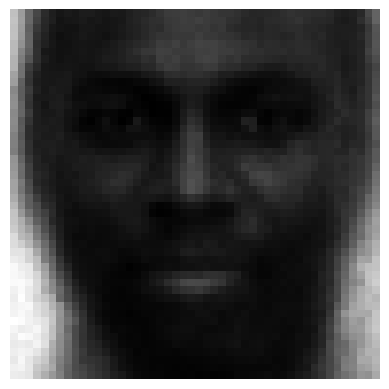

In [ ]:
plt.axis('off')
plt.imshow(preds[0].reshape(48, 48, 1), cmap='gray');

It's generated from the noise...

In [ ]:
def generate_dude(l1, l2, l3):
    latent_vars = np.array([[l1, l2, l3]])
    generated = np.array(decoder(latent_vars))
    generated = generated.reshape(48, 48, 1)
    plt.axis('off')
    plt.title('This dude is not real')
    plt.imshow(generated, cmap='gray')
    plt.show()

In [ ]:
latent_min = np.min(encoder(data).numpy()[:, 0])
latent_max = np.max(encoder(data).numpy()[:, 0])

latent_min2 = np.min(encoder(data).numpy()[:, 1])
latent_max2 = np.max(encoder(data).numpy()[:, 1])

latent_min3 = np.min(encoder(data).numpy()[:, 2])
latent_max3 = np.max(encoder(data).numpy()[:, 2])

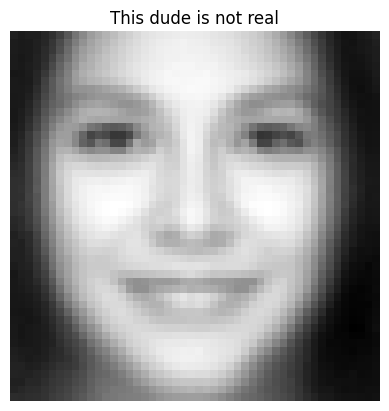

<function __main__.generate_dude(l1, l2, l3)>

In [ ]:
face_image_generator = widgets.interact(
    generate_dude,
    l1=(latent_min, latent_max),
    l2=(latent_min2, latent_max2),
    l3=(latent_min3, latent_max3),
)

display(face_image_generator)

Perfection!

Ps: THANKS to this guy: https://www.youtube.com/@gcdatkin <br>
And this video: https://www.youtube.com/watch?v=ZfxNcO6BqDo&list=LL&index=1 <br>
VEEEERY USEFULL AND UNDERRATED <br>
And as it works well (I spent 2 hours on it and 1 hour on AMD GPU activation for tf) now I made a cocktail, and now I'll play Gmod!